# Gaussian Kernel method

## Introduction

In this notebook, we implement the Gaussian Kernel method while taking into account the following experimental constraints:

1. The probabilities are supposed unknown and we use sampling instead.
2. The circuit parameters can only be controlled in a discrete manner. We also take into account noise.
3. Instead of supposing a number resolving detection, we suppose that we only have threshold detection.

## Sampling

Sampling is simulated numerically by taking the threshold probabilities and drawing $\text{N_DRAW}$ values according to the aforementioned probability law. These probabilities are computed using the SLOS backend.

In [1]:
def noisy_prob(s1, input_state):
    prob_vals=new_all_state_prob(s1, input_state, threshold_map, threshold_states)[1]
    sum_vals=np.sum(prob_vals)
    sample=np.random.choice(np.arange(len(prob_vals)), size=(N_DRAW,), p=prob_vals/sum_vals)
    res=[]
    for i in range(len(prob_vals)):
        res.append(np.count_nonzero(sample==i))
    return sum_vals * np.array(res) / np.sum(res)

## Parameters noise

The tension controlling the phase shifters is discrete, hence inducing a "noise". We should also take into account other sources of noise that we call "thermic noise".

In [2]:
N_DRAW=1000
step = 6.5 * 1e-3 # increment of phase control
thermic_noise=1e-3 # thermic noise (includes other sources of noise)

In [3]:
def noisy_angle(angle):
    """
    Computes the angle observed by the phase shifter due to the discretization of the input voltage.
    """
    return angle - np.remainder(angle, step)

## Threshold detection

We encode threshold detection through the following process:

1. We convert the output basis state family into their threshold detection equivalent (pre-computation).
2. We search this threshold basis indices in the threshold "basis" (pre-computation).
3. Each time the threshold probabilities are needed, we use the SLOS backend so as to compute the number resolving detection probabilities. Afterwards, we use our pre-computed correspondance between number resolving and threshold basis elements to compute the needed probabilities.

In [4]:
def convert_threshold(m, n):
    """
    Returns a list that maps each state to its threshold detection
    
    Input:
        m: number of modes
        n: number of photons
    """
    s1=pcvl.BackendFactory().get_backend("SLOS")(pcvl.Matrix.random_unitary(m))
    states_list=list(s1.allstate_iterator(pcvl.BasicState([n] + [0]*(m - 1))))
    res=[]
    for state in states_list:
        state_list=list(state)
        threshold_state=[]
        for r in range(m):
            if state_list[r] > 0:
                threshold_state.append(1)
            else:
                threshold_state.append(0)
        res.append(pcvl.BasicState(threshold_state))
    return res

In [5]:
def idx_threshold(m, n):
    """
    Returns the indices of the number resolving detection basis in the threshold detection basis as well as the threshold basis.
    
    Input:
        m: number of modes
        n: number of photons
    """
    threshold_states=convert_threshold(m, n)
    
    list_bin=[list(map(int, list(str(bin(i))[2:]))) for i in range(1, 2**m)]
    for i in range(len(list_bin)):
        list_bin[i]=[0]*(m-len(list_bin[i])) + list_bin[i]
    list_bin=list(map(pcvl.BasicState, list_bin))
    
    res=[]
    for r in range(len(threshold_states)):
        for s in range(len(list_bin)):
            if list_bin[s]==threshold_states[r]:
                res.append(s)
    return res, list_bin

In [6]:
def new_all_state_prob(s1, input_state, threshold_map, threshold_states):
    """
    Computes the probabilites in the threshold basis
    """
    s1.compile(input_state)
    probs_number=s1.all_prob(input_state)
    probs=np.zeros((len(threshold_states,)))
    
    for i in range((len(probs_number))):
        probs[threshold_map[i]]+=probs_number[i]
    return threshold_states, probs

## Learning of the quantum kernel

Here, we follow the same procedure as in our ideal quantum Gaussian kernel notebook. Nevertheless, we use a more complex circuit in order to compensate the diminishing expressivity due to threshold detection.

In [7]:
import numpy as np
import perceval as pcvl
import perceval.lib.symb as symb
from math import comb
import time
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy.optimize import basinhopping, dual_annealing
from multiprocessing import Pool

### Definition of the constants, the circuit and the simulator

Instead of using the circuit of <a href="https://arxiv.org/abs/2107.05224v1">Gan et al</a>, we use a 3-mode circuit for generating the Gaussian kernel. We suppose that the input state is $|n,0,0>$, $n=10$.

In [29]:
training_set = [] # training vector of the kenrel
m = 3 # number of modes
n = 10 # number of photons
input_state = pcvl.BasicState([n, 0, 0]) # |n, 0>
delta = pcvl.P("delta") # parameter x_r,i = gamma * (w_r . x_i + b_r)
k = 1
a = 6 # range of the lambda parameter
fock_dim = comb(n + m - 1, n) # dimension of the Fock subspace Phi_m,n
threshold_map, threshold_states=idx_threshold(m, n)
sigma=1

In [30]:
simulator_backend = pcvl.BackendFactory().get_backend("SLOS") # definition of the backend
s1 = simulator_backend(pcvl.Matrix.random_unitary(m)) # some matrix that will be changed later
s1.compile(input_state)
c=pcvl.Circuit(m=m).add((0,1), symb.BS()).add(0,symb.PS(delta)).add((0,1), symb.BS()).add((1,2), symb.BS()).add((0,1), symb.BS()).add((1,2), symb.BS())
pcvl.pdisplay(c)

In [31]:
c.U

Matrix([
[ sqrt(2)*(exp(I*delta) - 1)/4 - exp(I*delta)/4 - 1/4,    I*(sqrt(2)*(exp(I*delta) + 1) - exp(I*delta) + 1)/4,              -1/2],
[            I*(sqrt(2)*exp(I*delta) - 4 + sqrt(2))/8,              -sqrt(2)*exp(I*delta)/8 - 1/2 + sqrt(2)/8, I*(sqrt(2) + 2)/4],
[-exp(I*delta)/2 - sqrt(2)*exp(I*delta)/8 - sqrt(2)/8, I*(-4*exp(I*delta) - sqrt(2)*exp(I*delta) + sqrt(2))/8,   1/2 - sqrt(2)/4]])

### Definition of the approximate quantum kernel

In [10]:
def quantum_value1(d, lambda_random):
    """
    Wrapper that define the quantum circuit computation. Here the input is the value delta = || x - y ||^2
    """
    delta.set_value(np.random.normal(loc=noisy_angle(d), scale=thermic_noise))
    U = c.compute_unitary(use_symbolic=False)
    s1.U = U
    return np.sum(np.multiply(noisy_prob(s1, input_state), 1e6 * lambda_random))

def quantum_value2(x1, x2, lambda_random):
    """
    Wrapper that define the quantum circuit computation. Here the input is the pair of points x1 and x2.
    The code computes || x1 - x2 ||^2 and then applies the quantum circuit
    """
    z = x1 - x2
    d = z @ z
    return quantum_value1(d, lambda_random)

#### Computation of the loss function

Here, we used the following quadratic loss function:

\begin{equation*}
    \mathcal{L}(\overrightarrow{\delta}, \lambda) = \frac{1}{2 N} \sum_{i = 1}^N \left(f(\delta_i, \lambda) - e^{- \frac{\delta_i}{2 \sigma^2}} \right)^2
\end{equation*}

where $\overrightarrow{\delta}$ is the training vector.

In [11]:
def computation(lambda_random):
    """
    Computes the quadratic loss function over the training set
    """
    global training_set
    loss = 0
    for i in range(len(training_set)):
        fvalue = quantum_value1(training_set[i], lambda_random)
        loss += np.linalg.norm(fvalue - np.exp(-training_set[i]/ (2 * sigma ** 2)))**2
    loss /= (2 * len(training_set))
    print("fun ", loss,":" , lambda_random)
    return loss

#### Training

In order to train our quantum kernel, we draw values from the law $U(0, 3)$. Sadly for us, we cannot train the quantum kernel for values outside of this range, since the function does not have a symmetry we could use. Some may suggest the following trick, which is "equivalent" to what we did in the RKS notebook:

\begin{equation*}
\exp(-x) = \left[\exp\left(-\frac{x}{\omega}\right)\right]^{\omega}
\end{equation*}

In spite of being a correct observation, being able to use this trick means that we are able to compute $a^{b}$ classicaly for all $a$ and $b$, hence the absence of need to a quantum kernel.

We **strongly** advise the user to keep the default values of the parameters (maybe change $N$).

In [12]:
def training(N):
    """
    Generates the training set
    Minimizes the loss function using scipy.optimize.dual_annealing
    
    Input:
    
        N: size of the training set
        niter_basin: number of calls to scipy.optimize.basinhopping
        niter_arg: number of basin hopping iteration in the function scipy.optimize.basinhopping.
    """
    global training_set
    training_set = np.random.uniform(low=0, high=3, size=N) # define the training vector
    lambda_random = np.random.uniform(size=2**m-1, low=0, high=a) # new random lambda parameter
    res = dual_annealing(computation, [(-1.5*a, 1.5*a)]*(2**m-1), no_local_search=False, maxfun=1000) # minimization via basinhopping
    return res.fun, res.x

We use multi-processing in order to allow for different walks in the parameters space. At the end, we take the best result.

In [58]:
n_pool=10
if __name__ == '__main__':
    with Pool(n_pool) as p:
        results=p.map(training, [100 + i for i in range(n_pool)])

fun  fun 0.5748979825818787  fun 2.4267125610160334fun : fun   0.7289352327580735  fun :0.9045863251656109[ 2.07459901 -6.32963703 -2.41722107 -2.62716554  2.62152799 -8.9148241
  6.99423189]   0.5557722395645113
 :3.2959111283858253 : [-2.62716554  2.62152799 -8.9148241   6.99423189 -6.95452841 -2.00073325
 -5.72965002] : 
[-2.00073325 -5.72965002  6.92643457  5.55801135 -5.41618189 -6.33232594
  7.94608376]: [-6.95452841 -2.00073325 -5.72965002  6.92643457  5.55801135 -5.41618189
 -6.33232594] 
[ 6.99423189 -6.95452841 -2.00073325 -5.72965002  6.92643457  5.55801135
 -5.41618189]

[-6.32963703 -2.41722107 -2.62716554  2.62152799 -8.9148241   6.99423189
 -6.95452841]
fun  2.7256008946003334 : [ 8.91139797  2.07459901 -6.32963703 -2.41722107 -2.62716554  2.62152799
 -8.9148241 ]fun 
 0.1233475404995802 : [-2.41722107 -2.62716554  2.62152799 -8.9148241   6.99423189 -6.95452841
 -2.00073325]
fun  0.565179539829465 : fun  [-8.9148241   6.99423189 -6.95452841 -2.00073325 -5.72965002  6.926

In [59]:
for result in results:
    print(result)

(0.001834064462410894, array([-0.40387744, -1.15174805,  0.92793007,  7.67459958,  4.00054741,
       -8.89678858,  1.27743996]))
(0.002936798545061011, array([ 5.99064701,  1.00506699,  6.8636764 ,  0.49763505,  4.25818386,
       -1.63435763,  0.54434673]))
(0.009065187871628421, array([-0.94417208,  8.19267181, -6.70155672,  7.65338461,  5.05507796,
        0.21151052,  0.02024842]))
(0.002683635630333616, array([ 8.22627907, -4.26978351,  7.22543493,  4.28549072,  2.7896283 ,
       -7.92123803,  1.45655346]))
(0.0037618946443914317, array([ 1.84440396,  2.82554203, -2.25542421,  4.81962814,  3.1358516 ,
       -3.10341943,  1.20923109]))
(0.0008951443444963675, array([-1.77609191, -4.54121664,  4.31605767, -5.62008095,  4.21876585,
       -2.93219981,  0.89428519]))
(0.009217932791531594, array([-7.96241211,  7.38359327,  7.15300817,  8.18407846,  2.92988014,
        1.37270978,  1.22439702]))
(0.0014437947363037651, array([ 7.86934382,  1.59926541,  5.53524871,  6.16759187,  3.85

## Use of a pre-computed $\lambda$

### Importation of modules

In [13]:
import numpy as np
import perceval as pcvl
import perceval.lib.phys as phys
from math import comb
import sklearn.datasets as skdt
import time
from scipy.optimize import basinhopping
from copy import deepcopy
import matplotlib.pyplot as plt
import pybobyqa
from tqdm import tqdm

### Defintion of constants

A particular attention should be given to the regularization coefficient $\alpha$. Indeed, the Gaussian kernel classification is heavily dependent on its value. This regularization coefficient limits the expressive power of the classifier (relative to the Gaussian kernel). It should thus be fine-tuned accordingly to the complexity of the considerated dataset. The introduction of noise and threshold detection requires an increase in the values of $\alpha$.

We advise the user to choose the following values:

1. linear datasets: $\alpha = 10$
2. Circular datasets: $\alpha = 15$
3. Moon datasets: $\alpha = 3$

The wrapper at the end of the notebook allows the user to change the regularization parameter value. No need to do it here.

In [14]:
h = .1    # step size in the mesh
alpha = 1  # regularization term

#### Value fo $\lambda$

The value of $\lambda$ was found through the minimization of the aformentioned loss function.

The loss is: $0.0008951443444963675$.

In [15]:
lambda_random =np.array([-1.77609191, -4.54121664,  4.31605767, -5.62008095,  4.21876585,
       -2.93219981,  0.89428519]) 

##### Comparaison between the quantum kernel and the real kernel
Since we can compute the real and quantum kernels, we can compare the accuracy of the approximation.

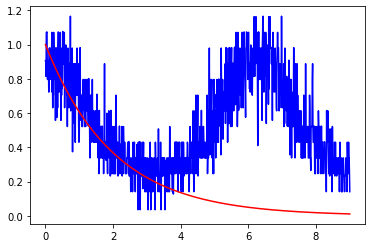

In [16]:
N_DRAW=10
X = np.linspace(0, 9, num = 1000)
plt.plot(X, [quantum_value1(x, lambda_random) for x in X], 'b')
plt.plot(X, np.exp(-X/ (2 * sigma ** 2)), 'r')
plt.show()

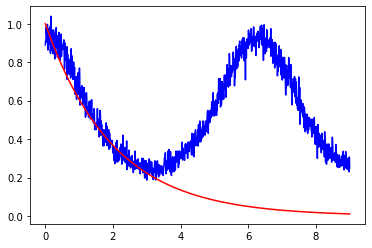

In [17]:
N_DRAW=100
X = np.linspace(0, 9, num = 1000)
plt.plot(X, [quantum_value1(x, lambda_random) for x in X], 'b')
plt.plot(X, np.exp(-X/ (2 * sigma ** 2)), 'r')
plt.show()

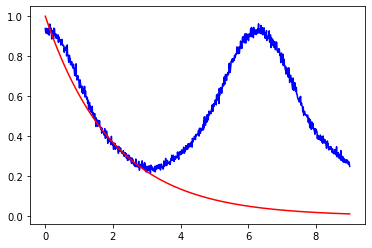

In [18]:
N_DRAW=1000
X = np.linspace(0, 9, num = 1000)
plt.plot(X, [quantum_value1(x, lambda_random) for x in X], 'b')
plt.plot(X, np.exp(-X/ (2 * sigma ** 2)), 'r')
plt.show()

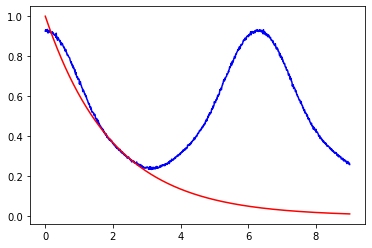

In [19]:
N_DRAW=10000
X = np.linspace(0, 9, num = 1000)
plt.plot(X, [quantum_value1(x, lambda_random) for x in X], 'b')
plt.plot(X, np.exp(-X/ (2 * sigma ** 2)), 'r')
plt.show()

### Data generation

The generated data is normalized as usual. Not only does it make the graphical representation easier, it guarentees that our values will remain more or less within the range (0, 3).

In [20]:
def normalizeX(z):
    """
    Sets the values between -1 and 1 linearly
    """
    zmax = np.max(z)
    zmin = np.min(z)
    return 2 * (z - zmin) / (zmax - zmin) - 1

def normalizey(z):
    """
    Values between -1 and 1 by replacing 0 values by -1
    """
    for i in range(len(z)):
        if z[i] == 0:
            z[i] = -1
    return z

def generate_data(type, N, noise_param):
    """
    Generates random datasets of different types
    type == 0: linear dataset
    type == 1: circular dataset
    type == 2: moon dataset
    
    >> Default noise values:
        - linear dataset: 1.5
        - circular dataset: 0.03
        - moon dataset: 0.1
    """
    if type == 0 and noise_param is None: # linear
        X, y = skdt.make_blobs(n_samples=N, centers=2, n_features=2, cluster_std = 1.5)
    elif type == 0: # linear
        X, y = skdt.make_blobs(n_samples=N, centers=2, n_features=2, cluster_std = noise_param)
    elif type == 1 and noise_param is None: # circlar
        X, y = skdt.make_circles(n_samples=N, noise=0.03)
    elif type == 1: # circlar
        X, y = skdt.make_circles(n_samples=N, noise= noise_param)
    elif type == 2 and noise_param is None: # moon
        X, y = skdt.make_moons(n_samples=N, noise=0.1)
    elif type == 2: # moon
        X, y = skdt.make_moons(n_samples=N, noise=noise_param)
    else:
        raise(ValueError("Invalid value of type. Enter help(generate_data) for more information"))
    # data normalization
    X = normalizeX(X)
    y = normalizey(y)
    return X, y

### Computation of the kernel matrix

In [21]:
def quantum_K_matrix(X):
    """
    Computation of the quantum Gaussian kernel
    """
    N = len(X)
    K = np.zeros((N, N))
    print(">>> Computing quantum kernel matrix")
    for i in tqdm(range(N)):
        for j in range(i, N):
            K[i, j] = quantum_value2(X[i], X[j], lambda_random)
    for i in range(N):
        for j in range(i): # Gaussian kernel matrix is symmetric
            K[i, j] = K[j, i]
    return K

### Resolution of the linear sytem

Even though <a href="https://arxiv.org/abs/2107.05224v1">Gan et al </a> claims that $\beta$ is computed through the formula:

\begin{equation*}
    \beta = (K + \alpha I)^{-1} y,
\end{equation*}

it is well-known that a linear system resolution is faster than a matrix inversion and a matricial product. We therefore encoded this formula through the resolution of the linear system:

\begin{equation*}
    (K + \alpha I) \ \beta = y
\end{equation*}

In [22]:
def solve(K, X, y):
    """
    Linear system resolution
    Input:
        K: kernel matrix
        X: training input points
        y: training labels
    """
    N = len(X)
    return np.linalg.solve(K + alpha * np.eye(N), y)

### Computation of the score

The score uses the usual formula. However, it is computed by using a yet unused set (what one may call a test set).

In [23]:
def quantum_scoring(X, y, X_train, beta):
    """
    Computes the score over the given set X and labels y using the given beta vector.
    """
    cpt = 0
    print(">>> Scoring")
    for i in tqdm(range(len(X))):
        fvalue = 0
        for j in range(len(X_train)): # computation of the classifier
            fvalue += beta[j] * quantum_value2(X[i], X_train[j], lambda_random)
        if np.sign(fvalue) == y[i]: cpt += 1
    return cpt / len(X)

### Graphical representation

The plot shows another unused set with the classification of the square $[-1.1, 1.1] \times [-1.1, 1.1]$.

In [24]:
def plot_quantum_fitting(X, y, beta, X_train, ret):
    """
    Defines the graphical representation which contains some points and their corresponding labels,
    the background is the classification of the square [-1.1, 1.1] x [-1.1, 1.1] and the score (given
    in the input) written in the title.
    """
    plt.figure(figsize=(8,8)) # Generate figure

    # create a mesh for the background
    N = len(X_train)
    xx = np.arange(-1.1, 1.1, h)
    yy = np.arange(-1.1, 1.1, h)
    zs = np.zeros((len(xx), len(yy)))
    print(">>> Plotting")
    for i in tqdm(range(len(xx))):
        for j in range(len(yy)):
            zs[i, j] = 0
            for k in range(N): # computation of the classifier
                zs[i, j] += beta[k] * quantum_value2(X_train[k], np.array([xx[i], yy[j]]), lambda_random)
            zs[i, j] = np.sign(zs[i, j])
    cs = plt.contourf(xx, yy, zs, cmap=plt.cm.coolwarm)
    plt.colorbar(cs)

    # Plot scatter points
    plt.scatter(
        X[y == -1, 1],
        X[y == -1, 0],
        s=4,
        label='-1',
        alpha=1,
        c = ["#0cf9f1"]
    )
    plt.scatter(
        X[y == 1, 1],
        X[y == 1, 0],
        s=4,
        label='1',
        alpha=1,
        c = ["#790909"]
    )

    plt.xlabel('x', fontsize=18)
    plt.ylabel('y', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    lgnd = plt.legend(fontsize=18)

    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1,1.1)
    for it in range(2):
        lgnd.legendHandles[it]._sizes = [40]
    plt.title("score = " + str(ret)) # write the score in the title
    plt.show()

### Wrapper

This wrapper calls the functions defined before. It starts by redefining $\alpha$, which turned out to be a *very important* parameter in the classification. Afterwards, it generates the data set (using the noise parameter if it is given) and divides it into three subsets (training, test and grapical representation). Then, it computes the kernel matrix and solves the linear system. Finally, it computes the score and shows the graphical representation.

In [25]:
def q_ker_fit(type, alpha_value, N = 100, noise_param=None):
    """
    Wrapper that uses a prepared quantum kernel in order to call all the classification steps.
    1. alpha redefinition and data generation
    2. Definition of beta by resolving the linear system
    3. Score computation
    4. Graphical representation
    
    >> Default noise values:
        - linear dataset: 1.5
        - circular dataset: 0.03
        - moon dataset: 0.1
    """
    global alpha
    alpha = alpha_value # alpha redefinition
    
    X, y = generate_data(type, N, noise_param)
    prop1 = int(0.8 * len(y))
    prop2 = int(0.9 * len(y))


    q_beta = solve(quantum_K_matrix(X[:prop1]), X[:prop1], y[:prop1]) # generate K-matrix and solve
    ret = quantum_scoring(X[prop1:prop2], y[prop1:prop2], X[:prop1], q_beta) # compute score
    print(">>>>>> quantum score: ", ret)

    plot_quantum_fitting(X[prop2:], y[prop2:], q_beta,  X[:prop1], ret) # show result


### Examples

As can be seen in the following examples, regularization manages to get rid of noise and sampling errors. Additionally, it can be seen that we get excellent results thanks to our new circuit.

>>> Computing quantum kernel matrix


100%|██████████| 800/800 [05:57<00:00,  2.24it/s]


>>> Scoring


100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


>>>>>> quantum score:  0.97
>>> Plotting


100%|██████████| 22/22 [07:25<00:00, 20.23s/it]


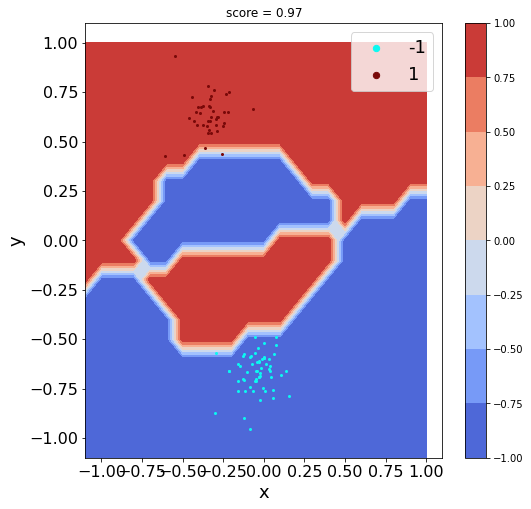

In [67]:
N_DRAW=100
q_ker_fit(0, 10, 1000)

>>> Computing quantum kernel matrix


100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


>>>>>> quantum score:  0.92
>>> Plotting


100%|██████████| 22/22 [08:51<00:00, 24.16s/it]


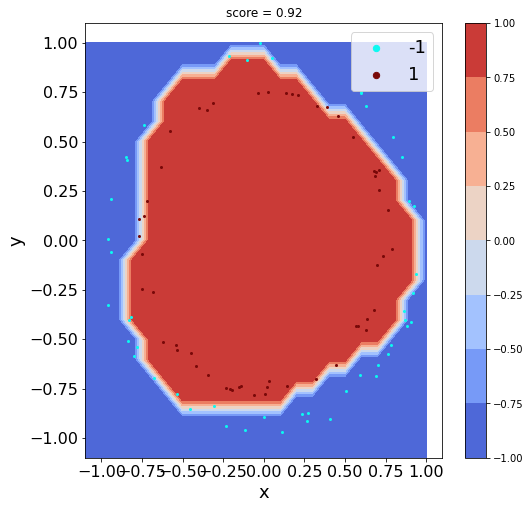

In [69]:
N_DRAW=10000
q_ker_fit(1, 15, 1000)

>>> Computing quantum kernel matrix


100%|██████████| 800/800 [06:12<00:00,  2.15it/s]


>>> Scoring


100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


>>>>>> quantum score:  1.0
>>> Plotting


100%|██████████| 22/22 [07:25<00:00, 20.25s/it]


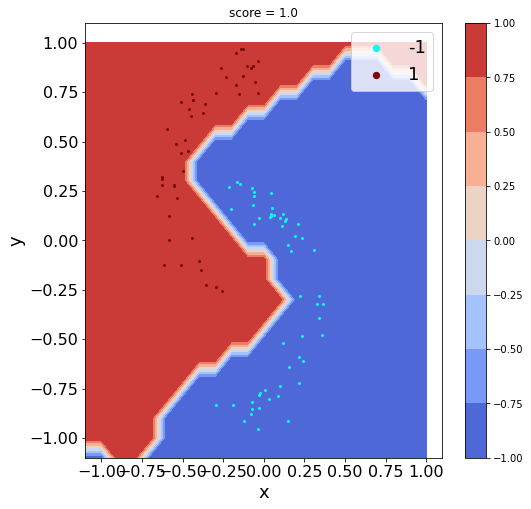

In [70]:
N_DRAW=1000
q_ker_fit(2, 3, 1000)